In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [119]:
df = pd.read_csv('data/xav_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   words              466 non-null    int64  
 1   key_hold_duration  466 non-null    object 
 2   interval           465 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.0+ KB


In [120]:
test = pd.read_csv('data/xav_test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   words              492 non-null    int64  
 1   key_hold_duration  492 non-null    object 
 2   interval           491 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.7+ KB


In [121]:
display(df)

,words,key_hold_duration,interval
0,84,53 ms,NaN
1,72,63 ms,-387.0
2,69,87 ms,-78.0
3,32,0 ms,-78.0
4,70,77 ms,-85.0
...,...,...,...
461,65,0 ms,-50.0
462,32,68 ms,-98.0
463,86,54 ms,-160.0
464,65,18 ms,-24.0


In [122]:
# create 2 copies to reshape the data
df1 = df.copy()
df2 = df.copy()

# drop interval column in df1, key hold duration in df2
df1.drop(['interval'], axis=1, inplace=True)
df2.drop(['key_hold_duration'], axis=1, inplace=True)

# drop first row in df1 and last row in df2
df1 = df1.drop(df1.index[-1]).reset_index(drop=True)
df2 = df2.drop(df2.index[0]).reset_index(drop=True)

# rename the columns 
df1.columns = ['word1', 'keyhold1']
df2.columns = ['word2', 'interval']

# remove ms from keyhold1 and change to integer
df1['keyhold1'] = df1['keyhold1'].str.replace('ms', '')
df1['keyhold1'] = df1['keyhold1'].astype(int)
df2['interval'] = abs(df2['interval'].astype(int))

# merge the two dataframes
df3 = pd.merge(df1, df2, left_index=True, right_index=True)
df3['word_combo'] = df3['word1'].astype(str) + ',' + df3['word2'].astype(str)
df3.drop(['word1', 'word2'], axis=1, inplace=True)
display(df3)

,keyhold1,interval,word_combo
0,53,387,"84,72"
1,63,78,"72,69"
2,87,78,"69,32"
3,0,85,"32,70"
4,77,162,"70,82"
...,...,...,...
460,24,50,"32,65"
461,0,98,"65,32"
462,68,160,"32,86"
463,54,24,"86,65"


In [123]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   keyhold1    465 non-null    int32 
 1   interval    465 non-null    int32 
 2   word_combo  465 non-null    object
dtypes: int32(2), object(1)
memory usage: 7.4+ KB


In [124]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
keyhold1,465.0,54.305376,38.354647,0.0,35.0,61.0,72.0,420.0
interval,465.0,116.959140,69.788446,3.0,70.0,99.0,141.0,438.0


In [125]:
df4 = df3.copy()

# drop keyhold1 from df4
df4.drop(['keyhold1'], axis=1, inplace=True)
display(df4)

,interval,word_combo
0,387,"84,72"
1,78,"72,69"
2,78,"69,32"
3,85,"32,70"
4,162,"70,82"
...,...,...
460,50,"32,65"
461,98,"65,32"
462,160,"32,86"
463,24,"86,65"


In [126]:
# find value counts of each word combo
df3['word_combo'].value_counts()

69,32    16
32,65    11
32,67    10
65,32     9
32,84     9
         ..
65,76     1
68,65     1
79,82     1
69,67     1
86,65     1
Name: word_combo, Length: 187, dtype: int64

In [127]:
# if multiple of same word combo exists take the average interval
df4 = df4.groupby('word_combo').mean().reset_index()
display(df4)

,word_combo,interval
0,"188,32",106.400000
1,"188,8",228.000000
2,"190,32",126.000000
3,"190,8",218.000000
4,"32,65",106.636364
...,...,...
182,"88,84",171.000000
183,"89,188",80.000000
184,"89,32",44.000000
185,"89,68",266.000000


In [128]:
df_train = df4.copy()
# train KMeans model
kmeans_train = KMeans(n_clusters=3, random_state=42, n_init=1000).fit(df4[['interval']])
df_train['cluster'] = kmeans_train.labels_
trained_centroids = kmeans_train.cluster_centers_
display(df_train)

,word_combo,interval,cluster
0,"188,32",106.400000,1
1,"188,8",228.000000,2
2,"190,32",126.000000,0
3,"190,8",218.000000,2
4,"32,65",106.636364,1
...,...,...,...
182,"88,84",171.000000,0
183,"89,188",80.000000,1
184,"89,32",44.000000,1
185,"89,68",266.000000,2


In [129]:
trained_centroids

array([[142.34437831],
       [ 74.94574453],
       [278.49074074]])

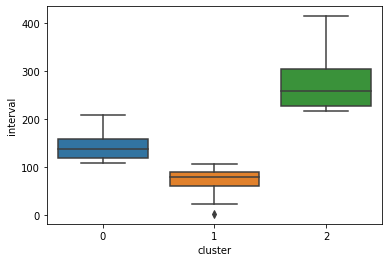

In [130]:
# plot boxplot of clusters
sns.boxplot(x='cluster', y='interval', data=df_train)
plt.show()

In [133]:
def data_cleaner(df):
    # create 2 copies to reshape the data
    df1 = df.copy()
    df2 = df.copy()

    # drop interval column in df1, key hold duration in df2
    df1.drop(['interval'], axis=1, inplace=True)
    df1.drop(['key_hold_duration'], axis=1, inplace=True)
    df2.drop(['key_hold_duration'], axis=1, inplace=True)

    # drop first row in df1 and last row in df2
    df1 = df1.drop(df1.index[-1]).reset_index(drop=True)
    df2 = df2.drop(df2.index[0]).reset_index(drop=True)

    # rename the columns 
    df1.columns = ['word1']
    df2.columns = ['word2', 'interval']

    # change interval to integer
    df2['interval'] = abs(df2['interval'].astype(int))

    # merge the two dataframes
    df3 = pd.merge(df1, df2, left_index=True, right_index=True)
    df3['word_combo'] = df3['word1'].astype(str) + ',' + df3['word2'].astype(str)
    df3.drop(['word1', 'word2'], axis=1, inplace=True)
    df4 = df3.copy()

    # if multiple of same word combo exists take the average interval
    df4 = df4.groupby('word_combo').mean().reset_index()

    return df4

In [134]:
test_final = data_cleaner(test)
display(test_final)

,word_combo,interval
0,"188,32",118.200000
1,"188,8",230.000000
2,"190,32",92.666667
3,"32,65",137.600000
4,"32,66",199.571429
...,...,...
190,"89,188",76.000000
191,"89,32",61.000000
192,"89,68",169.000000
193,"89,72",112.000000


In [98]:
kmeans_assign_clusters = KMeans(n_clusters=3, random_state=42, init=trained_centroids).fit(test_final[['interval']])
test_final['cluster'] = kmeans_assign_clusters.labels_
display(test_final)

,word_combo,interval,cluster
0,"188,32",118.200000,1
1,"188,8",230.000000,2
2,"190,32",92.666667,1
3,"32,65",137.600000,0
4,"32,66",199.571429,0
...,...,...,...
190,"89,188",76.000000,1
191,"89,32",61.000000,1
192,"89,68",169.000000,0
193,"89,72",112.000000,1


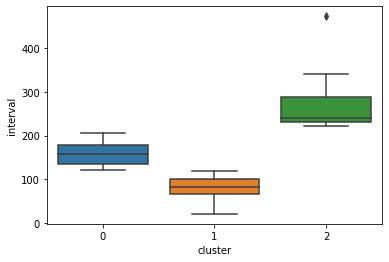

In [99]:
# boxplot of clusters for test_final
sns.boxplot(x='cluster', y='interval', data=test_final)
plt.show()

In [100]:
# inner join by word_combo between test_final and df_train
df_final = pd.merge(test_final, df_train, on='word_combo', how='inner')
display(df_final)

,word_combo,interval_x,cluster_x,interval_y,cluster_y
0,"188,32",118.200000,1,106.400000,1
1,"188,8",230.000000,2,228.000000,2
2,"190,32",92.666667,1,126.000000,0
3,"32,65",137.600000,0,106.636364,1
4,"32,66",199.571429,0,189.000000,0
...,...,...,...,...,...
168,"88,84",192.000000,0,171.000000,0
169,"89,188",76.000000,1,80.000000,1
170,"89,32",61.000000,1,44.000000,1
171,"89,68",169.000000,0,266.000000,2


In [101]:
correct = 0
for i in range(len(df_final)):
    if df_final['cluster_x'][i] == df_final['cluster_y'][i]:
        correct += 1

In [102]:
correct / len(df_final)

0.7109826589595376